In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

#import libraries
!pip3 install face_recognition

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition


#import libraries
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
from torch import nn
from torchvision import models


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=529317984fa8edb5dab0a0014772ffbd714bcb3897ba20e3d2ff4ca188e05fee
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [31]:
from torchvision import models
class EnhancedVideoModel(nn.Module):
    def __init__(self, num_classes, feature_dim=2048, num_lstm_layers=2, lstm_hidden_dim=1024, use_bidirectional=True):
        super(EnhancedVideoModel, self).__init__()
        # Using an updated version of ResNeXt with different parameters
        model_config = models.resnext101_32x8d(pretrained=True)
        self.features = nn.Sequential(*list(model_config.children())[:-2])

        # Adjust LSTM for bidirectionality and different hidden dimensions
        self.temporal_layers = nn.LSTM(input_size=feature_dim, hidden_size=lstm_hidden_dim,
                                       num_layers=num_lstm_layers, bidirectional=use_bidirectional)
        self.activation_fn = nn.ReLU()  # Changed to ReLU for stability
        self.regularization = nn.Dropout(0.5)  # Increased dropout for better generalization
        self.fc = nn.Linear(lstm_hidden_dim * 2 if use_bidirectional else lstm_hidden_dim, num_classes)
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, inputs):
        batch, sequences, channels, height, width = inputs.size()
        inputs_reshaped = inputs.view(batch * sequences, channels, height, width)
        conv_outputs = self.features(inputs_reshaped)
        pooled_outputs = self.global_pool(conv_outputs)
        pooled_outputs = pooled_outputs.view(batch, sequences, -1)
        lstm_out, _ = self.temporal_layers(pooled_outputs)
        temporal_features = torch.mean(lstm_out, dim=1)
        activated_features = self.activation_fn(temporal_features)
        final_output = self.fc(self.regularization(activated_features))
        return conv_outputs, final_output

In [32]:
# im_size = 112
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# sm = nn.Softmax(dim=1)
# inv_normalize = transforms.Normalize(mean=-1 * np.divide(mean, std), std=np.divide([1, 1, 1], std))

# def im_convert(tensor):
#     """ Convert a PyTorch tensor into an image format for display. """
#     tensor = tensor.to("cpu").clone().detach()
#     if tensor.dim() == 4:
#         tensor = tensor.squeeze(0)  # Assuming batch size of 1
#     if tensor.dim() != 3:
#         raise ValueError(f"Expected tensor to be of 3 dimensions (C, H, W) but got {tensor.dim()} dimensions")

#     # Applying inverse normalization
#     inv_normalize = transforms.Normalize(
#         mean=[-m / s for m, s in zip(mean, std)],
#         std=[1 / s for s in std]
#     )
#     tensor = inv_normalize(tensor)
#     image = tensor.numpy().transpose(1, 2, 0)  # Reorder to (H, W, C)
#     image = (image * 255).clip(0, 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
#     return image

# def predict(model, img):
#     img = img.cuda()  # Ensure the tensor is on the GPU
#     fmap, logits = model(img)  # Get the feature map and logits from the model
#     logits = sm(logits)  # Apply softmax to logits
#     _, prediction = torch.max(logits, 1)  # Get the prediction
#     confidence = logits[:, prediction.item()].item() * 100  # Calculate confidence
#     print('Confidence of prediction:', confidence)

#     # Visualizing the last frame as an example
#     last_frame = img[0, -1, :, :, :]  # Assuming img is (N, seq_len, C, H, W)
#     img_converted = im_convert(last_frame)
#     plt.imshow(img_converted)
#     plt.show()

#     return [int(prediction.item()), confidence]

In [33]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def im_convert(tensor):
    """ Convert a PyTorch tensor into an image format for display. """
    tensor = inv_normalize(tensor)  # Apply inverse normalization
    image = tensor.numpy().transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
    return image

def predict(model, img):
    img = img.cuda()  # Ensure the tensor is on the GPU
    fmap, logits = model(img)  # Get the feature map and logits from the model
    logits = sm(logits)  # Apply softmax to logits
    _, prediction = torch.max(logits, 1)  # Get the prediction
    confidence = logits[:, prediction.item()].item() * 100  # Calculate confidence
    print('Confidence of prediction:', confidence)

    # Assuming 'self.fc' is the final linear layer used in your model
    weight_softmax = model.fc.weight.detach().cpu().numpy()
    class_idx = torch.argmax(logits, dim=1).item()  # Index of the predicted class
    cam_weights = weight_softmax[class_idx]  # Weights for the CAM of the predicted class

    # Generate the class activation map
    fmap = fmap.detach().cpu().numpy()[0]  # Assuming batch size of 1 for simplicity
    cam = np.dot(fmap.reshape((fmap.shape[0], -1)).T, cam_weights.T)
    cam = cam.reshape(fmap.shape[1:])  # Reshape to the spatial dimension of the feature map
    cam = cam - np.min(cam)  # Normalize the CAM to 0-1
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (112, 112))  # Resize to the output size
    cam = np.uint8(255 * cam)  # Scale CAM to 0-255
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)  # Apply the heatmap color mapping

    # Visualization of the last frame with heatmap overlay
    last_frame = img[0, -1, :, :, :].cpu()  # Extract last frame from batch
    img_converted = im_convert(last_frame)
    overlayed_image = cv2.addWeighted(img_converted, 0.6, heatmap, 0.4, 0)

    # Displaying the image with heatmap
    plt.imshow(overlayed_image)
    plt.title(f"Prediction: {['FAKE', 'REAL'][prediction.item()]} ({confidence:.2f}%)")
    plt.show()

    return [int(prediction.item()), confidence]


In [34]:
class ValidationDataset(Dataset):
    def __init__(self, video_names, sequence_length=20, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        vidObj = cv2.VideoCapture(video_path)
        success, frame = vidObj.read()
        count = 0
        while success and count < self.count:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            faces = face_recognition.face_locations(frame)
            if faces:
                top, right, bottom, left = faces[0]
                frame = frame[top:bottom, left:right]
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            count += 1
            for _ in range(int(100 / self.count)):  # Skip frames to diversify the sample
                success, frame = vidObj.read()
        frames = torch.stack(frames)
        return frames.unsqueeze(0)  # Add batch dimension if necessary


def im_plot(tensor):
    """Plotting function that undoes normalization and displays an image."""
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = inv_normalize(tensor).cpu().numpy().transpose(1, 2, 0)
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.show()


Processing video: /content/drive/MyDrive/new_Face_only_data/nxnmkytwze.mp4
Confidence of prediction: 97.50730395317078


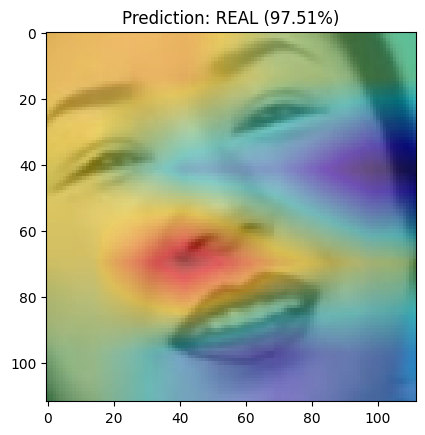

REAL
Processing video: /content/drive/MyDrive/new_Face_only_data/hierggamuo.mp4
Confidence of prediction: 99.82859492301941


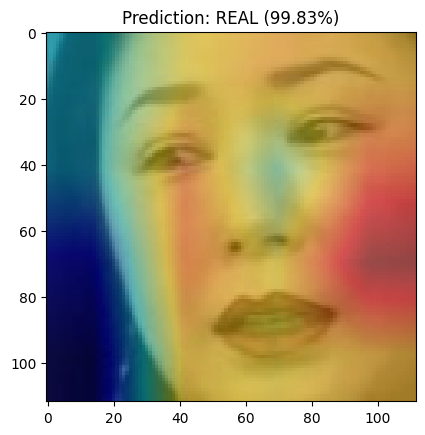

REAL
Processing video: /content/drive/MyDrive/new_Face_only_data/kthmgbrozc.mp4
Confidence of prediction: 99.27936792373657


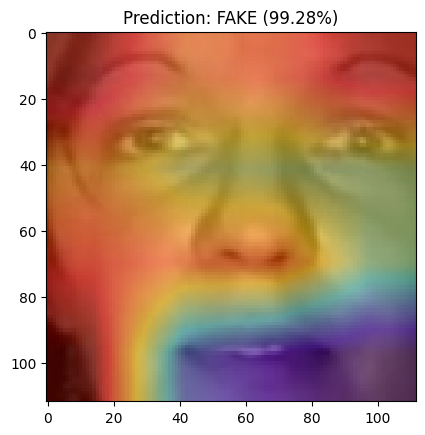

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/kiyvsruaai.mp4
Confidence of prediction: 68.79340410232544


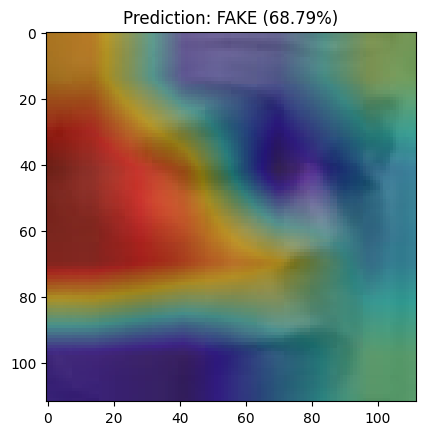

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/tfjnpnvwkd.mp4
Confidence of prediction: 98.44926595687866


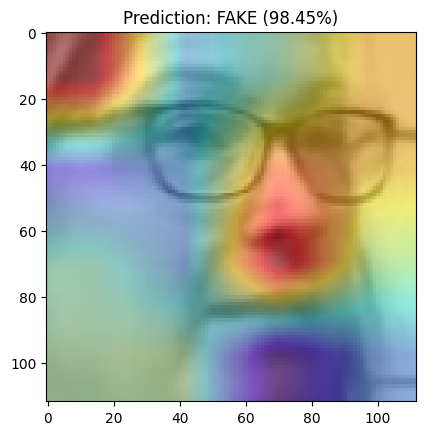

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/ibcwijeodg.mp4
Confidence of prediction: 82.54081606864929


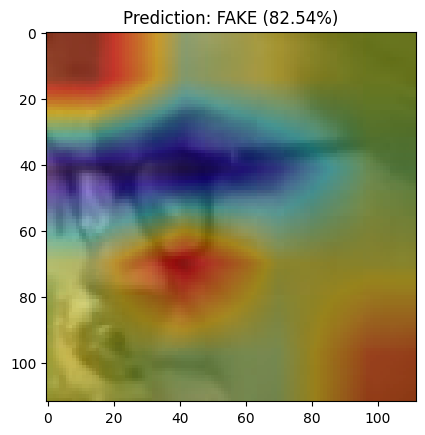

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/rmlzgerevr.mp4
Confidence of prediction: 85.18407344818115


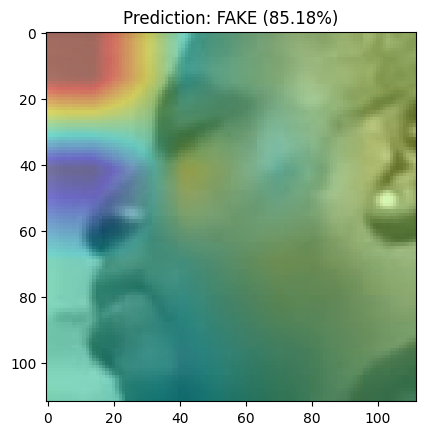

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/vlmllzbcbe.mp4
Confidence of prediction: 99.70990419387817


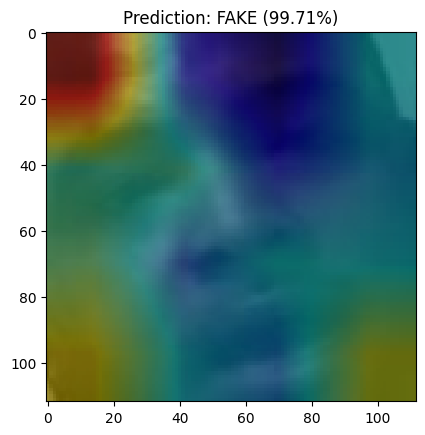

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/vqqvveifjn.mp4
Confidence of prediction: 87.68935799598694


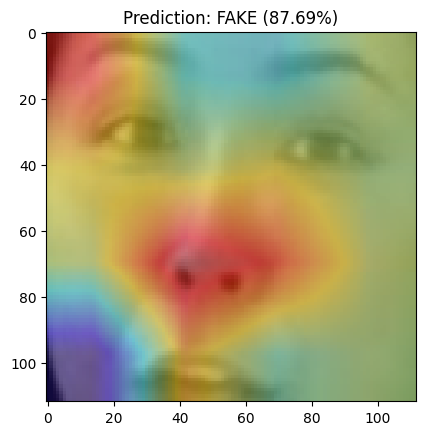

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/burglzjysn.mp4
Confidence of prediction: 91.64286851882935


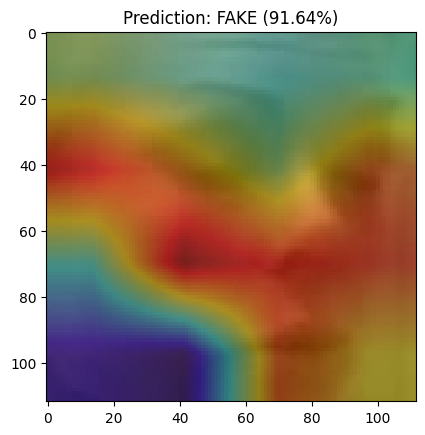

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/wjhpisoeaj.mp4
Confidence of prediction: 80.8254599571228


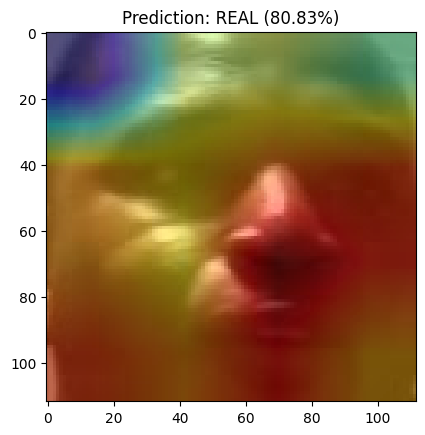

REAL
Processing video: /content/drive/MyDrive/new_Face_only_data/rvyvuuvdxs.mp4
Confidence of prediction: 99.747234582901


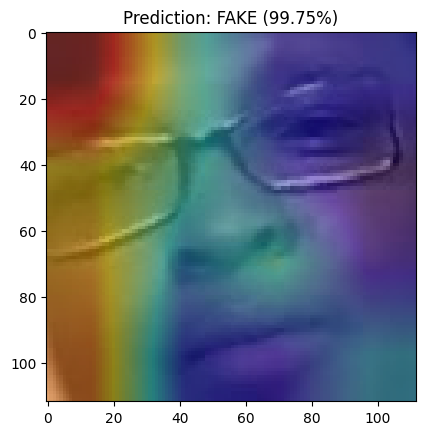

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/yjkcewkhhn.mp4
Confidence of prediction: 77.26927399635315


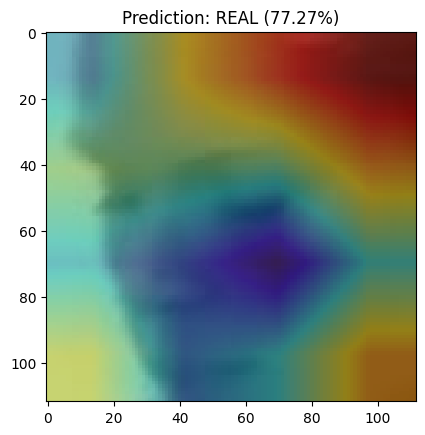

REAL
Processing video: /content/drive/MyDrive/new_Face_only_data/omphqltjdd.mp4
Confidence of prediction: 87.74861693382263


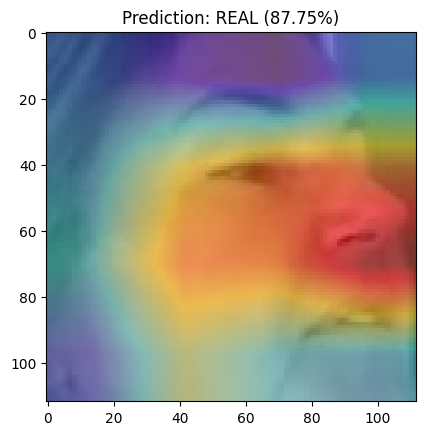

REAL
Processing video: /content/drive/MyDrive/new_Face_only_data/wcpfmnysix.mp4
Confidence of prediction: 98.23873043060303


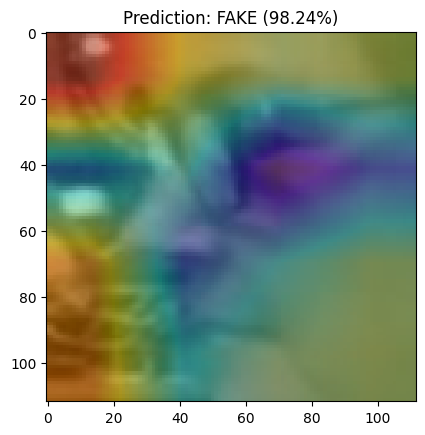

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/mttjelpgma.mp4
Confidence of prediction: 99.65670108795166


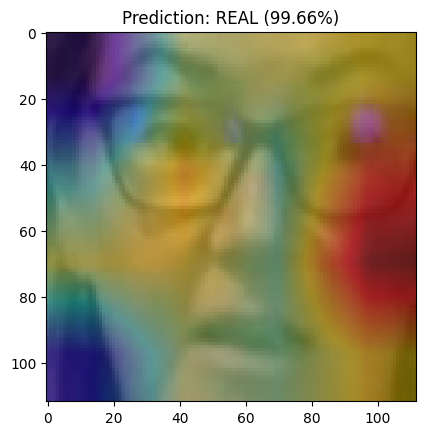

REAL
Processing video: /content/drive/MyDrive/new_Face_only_data/qknnpddobj.mp4
Confidence of prediction: 96.65083289146423


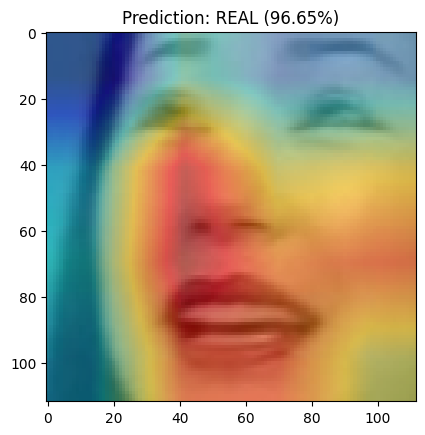

REAL
Processing video: /content/drive/MyDrive/new_Face_only_data/rayekvigxv.mp4
Confidence of prediction: 96.10574245452881


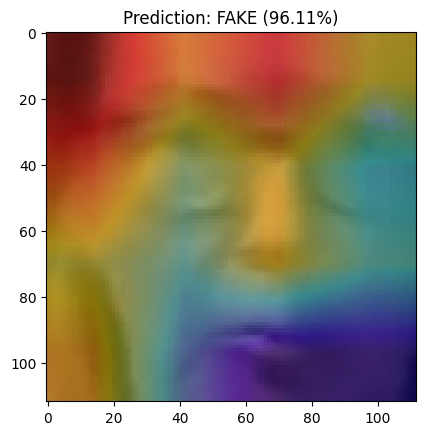

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/gbnzicjyhz.mp4
Confidence of prediction: 99.78106617927551


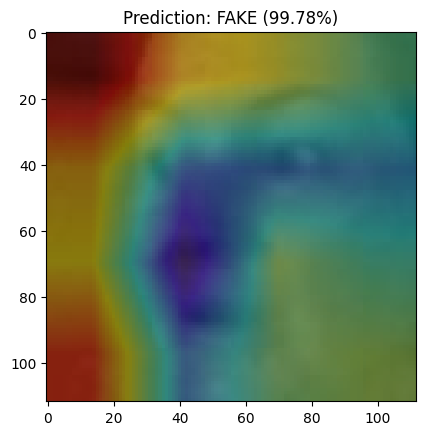

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/ztyvglkcsf.mp4
Confidence of prediction: 73.96025657653809


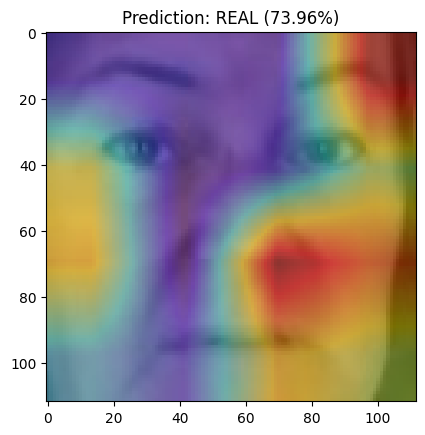

REAL
Processing video: /content/drive/MyDrive/new_Face_only_data/hjiixnernu.mp4
Confidence of prediction: 99.75366592407227


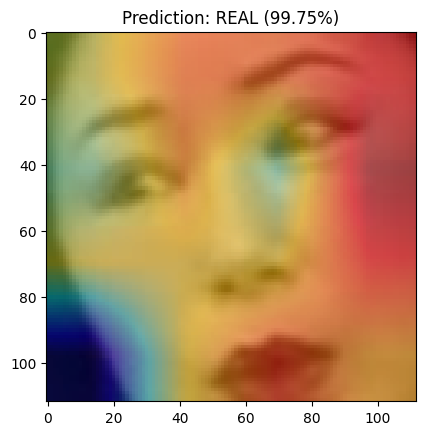

REAL
Processing video: /content/drive/MyDrive/new_Face_only_data/fcocsuznuz.mp4
Confidence of prediction: 99.44779872894287


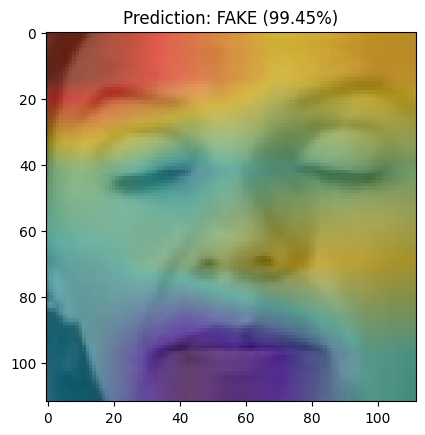

FAKE
Processing video: /content/drive/MyDrive/new_Face_only_data/uqguyibemu.mp4
Confidence of prediction: 99.81257319450378


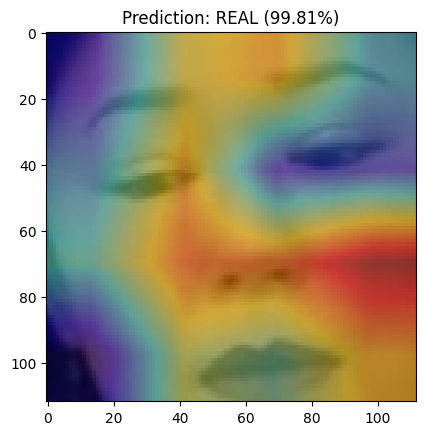

REAL


In [35]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define your video dataset
path_to_videos = ['/content/drive/MyDrive/new_Face_only_data/nxnmkytwze.mp4', '/content/drive/MyDrive/new_Face_only_data/hierggamuo.mp4', '/content/drive/MyDrive/new_Face_only_data/kthmgbrozc.mp4', '/content/drive/MyDrive/new_Face_only_data/kiyvsruaai.mp4', '/content/drive/MyDrive/new_Face_only_data/tfjnpnvwkd.mp4', '/content/drive/MyDrive/new_Face_only_data/ibcwijeodg.mp4', '/content/drive/MyDrive/new_Face_only_data/rmlzgerevr.mp4', '/content/drive/MyDrive/new_Face_only_data/vlmllzbcbe.mp4', '/content/drive/MyDrive/new_Face_only_data/vqqvveifjn.mp4', '/content/drive/MyDrive/new_Face_only_data/burglzjysn.mp4', '/content/drive/MyDrive/new_Face_only_data/wjhpisoeaj.mp4', '/content/drive/MyDrive/new_Face_only_data/rvyvuuvdxs.mp4', '/content/drive/MyDrive/new_Face_only_data/yjkcewkhhn.mp4', '/content/drive/MyDrive/new_Face_only_data/omphqltjdd.mp4', '/content/drive/MyDrive/new_Face_only_data/wcpfmnysix.mp4', '/content/drive/MyDrive/new_Face_only_data/mttjelpgma.mp4', '/content/drive/MyDrive/new_Face_only_data/qknnpddobj.mp4', '/content/drive/MyDrive/new_Face_only_data/rayekvigxv.mp4', '/content/drive/MyDrive/new_Face_only_data/gbnzicjyhz.mp4', '/content/drive/MyDrive/new_Face_only_data/ztyvglkcsf.mp4', '/content/drive/MyDrive/new_Face_only_data/hjiixnernu.mp4', '/content/drive/MyDrive/new_Face_only_data/fcocsuznuz.mp4', '/content/drive/MyDrive/new_Face_only_data/uqguyibemu.mp4']
video_dataset = ValidationDataset(path_to_videos, sequence_length=20, transform=train_transforms)

# Load your model
model = EnhancedVideoModel(num_classes=2).cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/Proposed.pt'))
model.eval()

# Loop through the dataset
for idx, video_path in enumerate(path_to_videos):
    print("Processing video:", video_path)
    video_data = video_dataset[idx]  # Get preprocessed video data
    prediction, confidence = predict(model, video_data)
    if prediction == 1:
        print("REAL")
    else:
        print("FAKE")